# Clustering and dimensionality reduction (15 marks)

## Task 4

In [1]:
# Import Libraries
import os
import pandas as pd  # use pandas to load data from CSV files
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
# Loading data
data_path = "breast_cancer_wisconsin_diagnostic"

files = os.listdir(data_path)
print(files)

['wdbc.data', 'wdbc.names']


In [3]:
# Loading data

feature_names = ["Feature{}".format(i) for i in range(1, 31)]
names = ["ID", "Diagnosis"] + feature_names
names
df = pd.read_csv(os.path.join(data_path, 'wdbc.data'), header=None, names=names)

In [4]:
# print(df.shape) # (569, 32)

In [5]:
# PCA functions

def sort_evals_descending(evals, evectors):
    index = np.flip(np.argsort(evals))
    evals = evals[index]
    evectors = evectors[:, index]
    if evals.shape[0] == 2:
        if np.arccos(np.matmul(evectors[:, 0], 1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
            evectors[:, 0] = -evectors[:, 0]
        if np.arccos(np.matmul(evectors[:, 1], 1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
            evectors[:, 1] = -evectors[:, 1]
    return evals, evectors


def pca(X):
    X_bar = X - np.mean(X, axis=0)
    cov_matrix = 1 / X.shape[0] * np.matmul(X_bar.T, X_bar)
    evals, evectors = np.linalg.eigh(cov_matrix)
    evals, evectors = sort_evals_descending(evals, evectors)
    score = np.matmul(X, evectors)
    return score, evectors, evals

In [6]:
# Convert data to useable format
dataset = df.to_numpy()
input_features = dataset[:, -30:]
input_features = input_features.astype(np.float32)

# Running PCA on input_features
score, evectors, evals = pca(input_features)

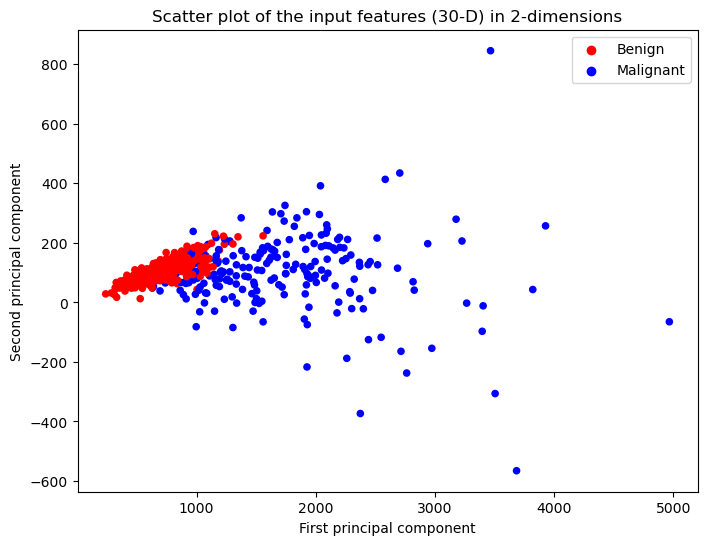

In [7]:
import matplotlib.pyplot as plt

# Your existing code
colors = {'B': 'red', 'M': 'blue'}
scores_pc2 = score[:,:2]

plt.figure(figsize=(8,6))
plt.scatter(scores_pc2[:, 0], scores_pc2[:, 1], c=df['Diagnosis'].map(colors), s=20, alpha=1)

plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Scatter plot of the input features (30-D) in 2-dimensions")

# Adding legend
for diagnosis, color in colors.items():
    if diagnosis == 'B':
        diagnosis = 'Benign'
    elif diagnosis =='M':
        diagnosis = 'Malignant'
    plt.scatter([], [], c=color, label=diagnosis)  # Empty scatter plots for legend

plt.legend(loc="best")
plt.show()


In [8]:
# Perform PCA using sklearn.decomposition.PCA
pca = PCA(n_components=5)
new_input_features = pca.fit_transform(input_features)

var_ratio = pca.explained_variance_ratio_
var_ratio_cumulative = [sum(var_ratio[:i + 1]) for i in range(len(var_ratio))]

print("Percentage of variance explained by PC1:", var_ratio[0])
print("Percentage of variance explained by PC2:", var_ratio[1])
print("Cumulative percentage of variance explained by PC1 and PC2", var_ratio_cumulative[1])

Percentage of variance explained by PC1: 0.9820444
Percentage of variance explained by PC2: 0.016176494
Cumulative percentage of variance explained by PC1 and PC2 0.9982208926230669


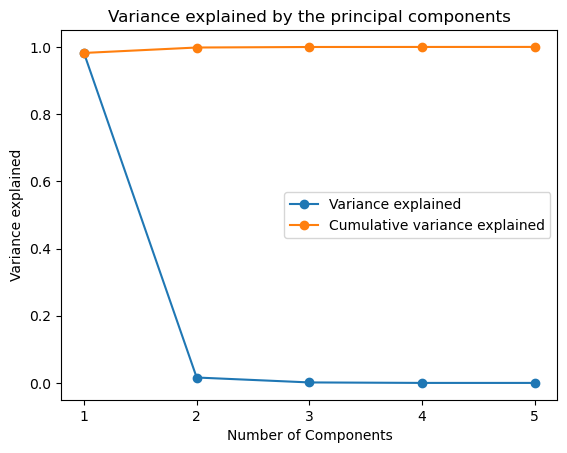

In [9]:
# Plotting graph of variance explained by the principal components
temp = np.arange(1,6,1)

x_values = range(len(temp))
plt.plot(x_values, var_ratio, label="Variance explained", marker="o")
plt.plot(x_values, var_ratio_cumulative, label="Cumulative variance explained", marker="o")

plt.xticks(x_values, temp)
plt.xlabel("Number of Components")
plt.ylabel("Variance explained")
plt.title("Variance explained by the principal components")
plt.legend(loc="best")
plt.show()

## Task 5

In [10]:
# Import Libraries
from matplotlib.colors import ListedColormap
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

In [11]:
# Train a GMM

gmm = GaussianMixture(n_components=2).fit(scores_pc2)
probabilities = gmm.predict_proba(scores_pc2)
# print(probabilities)

pred = gmm.predict(scores_pc2)
true_labels = df['Diagnosis'].to_numpy()
binary_true_labels = [1 if label == 'M' else 0 for label in true_labels]
# print(pred)
# print(true_labels)
# print(binary_true_labels)
print ("Accuracy score:", accuracy_score(pred, binary_true_labels))

Accuracy score: 0.9332161687170475


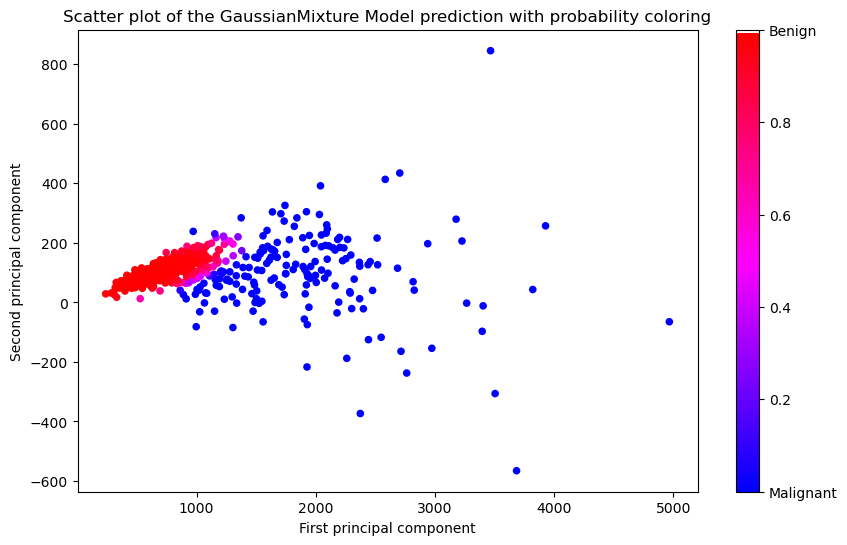

In [12]:
from matplotlib.colors import LinearSegmentedColormap
# Define the new color map
red = [1, 0, 0]  # Bright red
blue = [0, 0, 1]  # Bright blue

colors = [blue, (1, 0, 1), red]  # Include white for a smoother transition
n_bins = 100  # Number of bins in the colormap
cmap_name = "bright_blue_to_red"
bright_blue_to_red = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

colors = probabilities[:, 0]

# Plot the scatter graph
plt.figure(figsize=(10, 6))
# or can use cmap = 'coolwarm'
scatter = plt.scatter(scores_pc2[:, 0], scores_pc2[:, 1], c=colors, cmap=bright_blue_to_red, s=20, alpha=1)

plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Scatter plot of the GaussianMixture Model prediction with probability coloring")

# Adding colorbar
cbar = plt.colorbar(scatter)

# Set custom tick locations and labels
tick_labels = {0: 'Malignant', 1: 'Benign'}
ticks = ['Malignant', 0.2, 0.4, 0.6, 0.8, 'Benign']
# ticks = [tick_labels.get(tick, tick) for tick in cbar.get_ticks()]

cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(ticks)

plt.show()

# Classification with SVMs (10 marks)

## Task 7

In [13]:
# Import libraries
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

In [14]:
# Splitting dataset into training and testing components

X_tr = input_features[:450]
y_tr = binary_true_labels[:450]
X_test = input_features[450:]
y_test = binary_true_labels[450:]

# print(X_tr.shape)
# print(len(y_tr))
# print(X_test.shape)
# print(len(y_test))

In [15]:
# Hyperparameters to tune:
'''
SVC:
    kernel: yes (default: "rbf")
        - Specifies the kernel type to be used in the algorithm.
        - Values: ["linear", "poly", "rbf", "sigmoid"]
    gamma: yes (default: "scale")
        - Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
        - Values: ["scale", "auto", numeric values...]
    C: yes (default: 1.0)
        - Regularization parameter
        - Values: [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0], corresponds to numeric values above
        - Values: list(np.logspace(-5,1,7))
'''

'\nSVC:\n    kernel: yes (default: "rbf")\n        - Specifies the kernel type to be used in the algorithm.\n        - Values: ["linear", "poly", "rbf", "sigmoid"]\n    gamma: yes (default: "scale")\n        - Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.\n        - Values: ["scale", "auto", numeric values...]\n    C: yes (default: 1.0)\n        - Regularization parameter\n        - Values: [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0], corresponds to numeric values above\n        - Values: list(np.logspace(-5,1,7))\n'

In [16]:
# Train a SVM Classifier

# svm =  SVC()
# svm.fit(X_tr, y_tr)

# print("Training set accuracy: {}".format(svm.score(X_tr, y_tr)))
# print("Test set accuracy: {}".format(svm.score(X_test, y_test)))

# training_accuracy = svm.score(X_tr, y_tr)
# print("Training accuracy:", training_accuracy)

# testing_accuracy = svm.score(X_test, y_test)
# print("Testing accuracy:", testing_accuracy)

In [17]:
# kernel:

# define the parameter grid for kernel
param_grid = {'kernel': ["linear", "poly", "rbf", "sigmoid"]}

# Create an SVM classifier
svm = SVC()

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
kernels = param_grid['kernel']

[0.95111111 0.89555556 0.90444444 0.41777778]


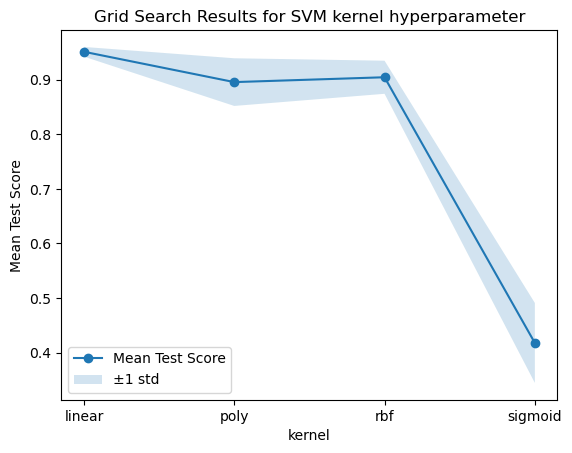

In [18]:
# Plot the results

print(results['mean_test_score'])

x_values = range(len(kernels))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')

plt.xticks(x_values, kernels)
plt.title("Grid Search Results for SVM kernel hyperparameter")
plt.xlabel("kernel")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

In [19]:
# gamma:

# define the parameter grid for gamma
# 'gamma': ['scale', 'auto', 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
param_grid = {'gamma': ["scale", "auto"] + list(np.logspace(-5,1,7))}

# Create an SVM classifier
svm = SVC()

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
gammas = param_grid['gamma']

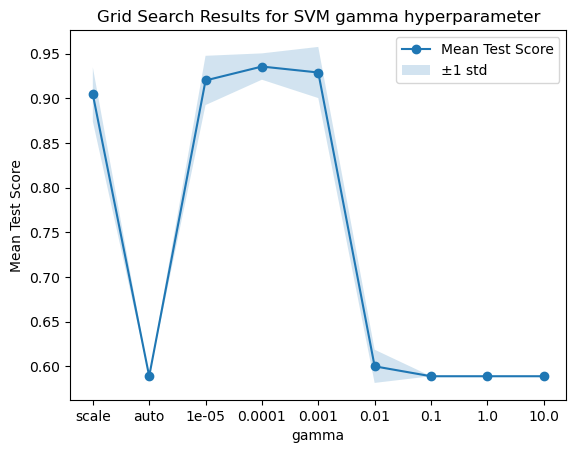

In [20]:
# Plot the results

x_values = range(len(gammas))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')

plt.xticks(x_values, gammas)
plt.title("Grid Search Results for SVM gamma hyperparameter")
plt.xlabel("gamma")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

In [21]:
# C:

# define the parameter grid for C
# 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = {'C': list(np.logspace(-4,2,7))}

# Create an SVM classifier
svm = SVC()

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Get the results
results = grid_search.cv_results_
Cs = param_grid['C']

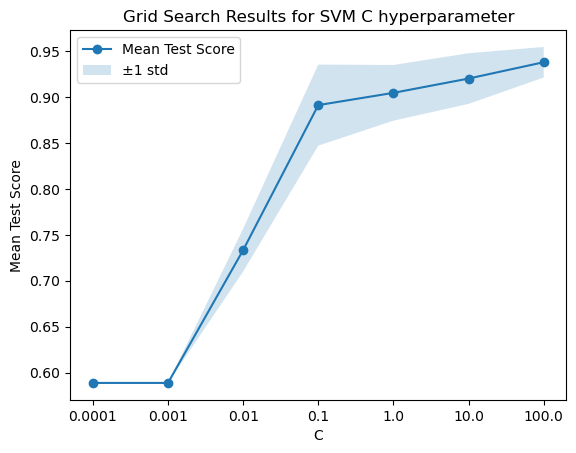

In [22]:
# Plot the results

x_values = range(len(Cs))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')

plt.xticks(x_values, Cs)
plt.title("Grid Search Results for SVM C hyperparameter")
plt.xlabel("C")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

## Finding the best SVM classifier using accuracy_score

In [23]:
# Best combination of hyperparameters for linear kernel
param_grid = {'C': [0.01, 0.05, 1, 2, 5, 7.5, 10, 20]}

# Create an SVM classifier
svm = SVC(kernel="linear")

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Print the best hyperparameters
best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", best_hyperparameters)

# Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)


Best Hyperparameters: {'C': 5}
Test Accuracy with Best Hyperparameters: 0.9327731092436975


In [24]:
# Best combination of hyperparameters for rbf kernel
param_grid = {'gamma': ["scale"] + list(np.logspace(-5,-1,5)),
              # 'C': [0.01, 0.05, 1, 2, 5, 7.5, 10, 20, 50, 100]
             'C': [0.01, 0.1, 1, 5, 10, 25, 50, 100]}

# Create an SVM classifier
svm = SVC(kernel="rbf")

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr, y_tr)

# Print the best hyperparameters
best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", best_hyperparameters)

# Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)


Best Hyperparameters: {'C': 25, 'gamma': 0.0001}
Test Accuracy with Best Hyperparameters: 0.9159663865546218


## Task 8

In [25]:
# print(scores_pc2.shape)
# Splitting dataset into training and testing components

X_tr_new = scores_pc2[:450]
y_tr_new = binary_true_labels[:450]
X_test_new = scores_pc2[450:]
y_test_new = binary_true_labels[450:]

# print(X_tr_new.shape)
# print(len(y_tr_new))
# print(X_test_new.shape)
# print(len(y_test_new))

In [26]:
# kernel:

# define the parameter grid for kernel
param_grid = {'kernel': ["linear", "poly", "rbf", "sigmoid"]}

# Create an SVM classifier
svm = SVC()

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr_new, y_tr_new)

# Get the results
results = grid_search.cv_results_
kernels = param_grid['kernel']

[0.93111111 0.90666667 0.90666667 0.24666667]


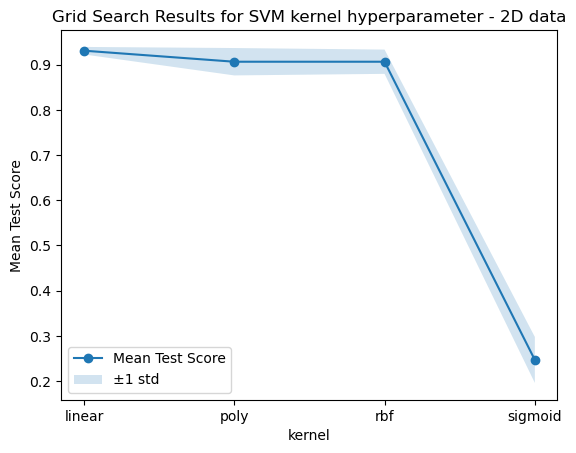

In [27]:
# Plot the results

print(results['mean_test_score'])

x_values = range(len(kernels))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')

plt.xticks(x_values, kernels)
plt.title("Grid Search Results for SVM kernel hyperparameter - 2D data")
plt.xlabel("kernel")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

In [28]:
# gamma:

# define the parameter grid for gamma
# 'gamma': ['scale', 'auto', 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
param_grid = {'gamma': ["scale", "auto"] + list(np.logspace(-5,1,7))}

# Create an SVM classifier
svm = SVC()

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr_new, y_tr_new)

# Get the results
results = grid_search.cv_results_
gammas = param_grid['gamma']

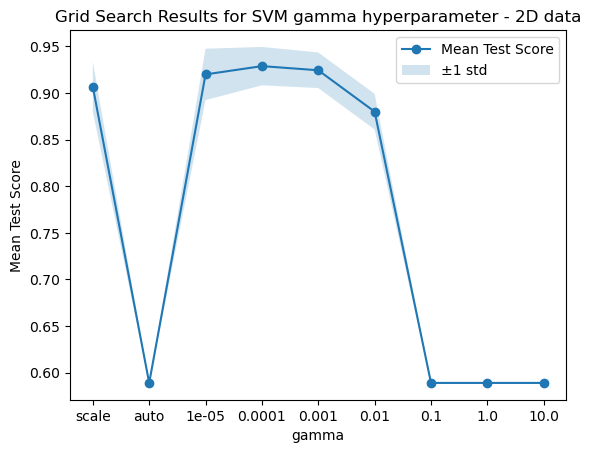

In [29]:
# Plot the results

x_values = range(len(gammas))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')

plt.xticks(x_values, gammas)
plt.title("Grid Search Results for SVM gamma hyperparameter - 2D data")
plt.xlabel("gamma")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

In [30]:
# C:

# define the parameter grid for C
# 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = {'C': list(np.logspace(-4,2,7))}

# Create an SVM classifier
svm = SVC()

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr_new, y_tr_new)

# Get the results
results = grid_search.cv_results_
Cs = param_grid['C']

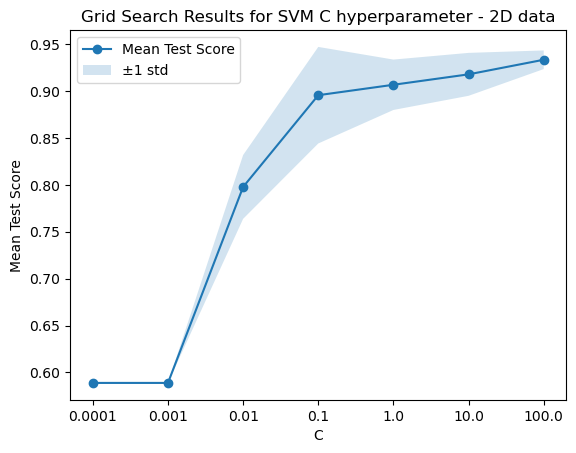

In [31]:
# Plot the results

x_values = range(len(Cs))
plt.plot(x_values, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(x_values, results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'], alpha=0.2, label='±1 std')

plt.xticks(x_values, Cs)
plt.title("Grid Search Results for SVM C hyperparameter - 2D data")
plt.xlabel("C")
plt.ylabel("Mean Test Score")
plt.legend(loc="best")
plt.show()

## Finding the best SVM classifier (for 2D data) using accuracy_score

In [32]:
# Best combination of hyperparameters for linear kernel
param_grid = {'C': [0.01, 0.05, 1, 2, 5, 7.5, 10, 20]}

# Create an SVM classifier
svm = SVC(kernel="linear")

# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_tr_new, y_tr_new)

# Print the best hyperparameters
best_hyperparameters = grid_search.best_params_
print("Best Hyperparameters:", best_hyperparameters)

# Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_new, y_test_new)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)


Best Hyperparameters: {'C': 0.01}
Test Accuracy with Best Hyperparameters: 0.9327731092436975


In [38]:
# Train an RBF kernel SVM Classifier with optimal hyperparameters found in Task 7

# Create an SVM classifier
svm = SVC(kernel="rbf", C=25, gamma=1e-05)
svm.fit(X_tr_new, y_tr_new)

# Evaluate the model on the test set using the best hyperparameters
test_accuracy = svm.score(X_test_new, y_test_new)
print("Test Accuracy with Best Hyperparameters:", test_accuracy)


Test Accuracy with Best Hyperparameters: 0.9159663865546218
